## 1.  Data upload

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# files in this folder are in the github folder, therefore for anyone wishing to run this code, you may need to change the path slightly
%cd /content/drive/MyDrive/T-Kan research paper
!ls


## 2. Library imports

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from google.colab import drive
import os
import torch.nn as nn
from datetime import datetime
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
from sklearn.metrics import classification_report



##  3. Data Loading and normalization





In [ ]:
def load_fi2010_data(file_path):
    """
    Loads the Z-score normalized FI-2010 data.
    Features: 1-144, Labels: 145-149 (for k=10, 20, 30, 50, 100)
    """
    data = np.loadtxt(file_path)
    features = data[:144, :].T
    # Labels are 1 (Up), 2 (Stationary), 3 (Down) in the raw file
    # Convert to 0, 1, 2 for standard CrossEntropy compatibility
    labels = data[144:, :].T - 1
    return features, labels


## 2. Sliding window generator

In [ ]:
#Temporal slicing to capture the "path-dependent" nature of the LOB.
def prepare_windows(features, labels, window_size=10, horizon_idx=0):
    """
    Slices features into windows and selects specific prediction horizon.
    horizon_idx: 0=k10, 1=k20, 2=k30, 3=k50, 4=k100
    """
    shape = features.shape
    num_windows = shape[0] - window_size + 1

    windowed_features = np.lib.stride_tricks.as_strided(
        features,
        shape=(num_windows, window_size, shape[1]),
        strides=(features.strides[0], features.strides[0], features.strides[1])
    )

    # Label is the one at the END of the window
    target_labels = labels[window_size - 1:, horizon_idx]

    return windowed_features, target_labels


##3. LSTM, CNN-LSTM and T-Kan (DEEPLOB) Implementation

In [ ]:

drive.mount('/content/drive')

%cd /content/drive/MyDrive/T-Kan\ research\ paper

SAVE_PATH = './project_checkpoints/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)

print(f"Current Directory: {os.getcwd()}")


In [ ]:
# Training and test paths
train_path = './Experiment-Datasets/Train_Dst_Auction_ZScore_CF_7.txt'
test_path = './Experiment-Datasets/Test_Dst_Auction_ZScore_CF_7.txt'

def load_and_window(file_path, window_size=10):
    data = np.loadtxt(file_path)
    features = data[:144, :].T
    labels = data[144, :].T - 1

    num_windows = features.shape[0] - window_size + 1
    X = np.lib.stride_tricks.as_strided(
        features,
        shape=(num_windows, window_size, 144),
        strides=(features.strides[0], features.strides[0], features.strides[1])
    )
    y = labels[window_size - 1:]
    return torch.FloatTensor(X.copy()), torch.LongTensor(y.copy())

# Spliting training file 80%:20% for validation
X_train_full, y_train_full = load_and_window(train_path)
split_idx = int(len(X_train_full) * 0.8)

X_train, y_train = X_train_full[:split_idx], y_train_full[:split_idx]
X_val, y_val = X_train_full[split_idx:], y_train_full[split_idx:]

# Loading test / blind set
X_test, y_test = load_and_window(test_path)

# Loaders
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=128, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=128, shuffle=False)

print(f"Train samples: {len(X_train)} | Val samples: {len(X_val)} | Test samples: {len(X_test)}")


In [ ]:
SAVE_PATH = './project_checkpoints/'
if not os.path.exists(SAVE_PATH):
   os.makedirs(SAVE_PATH)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- FIXED ARCHITECTURES ---

class LSTMModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(144, 64, 2, batch_first=True)
        self.fc = nn.Linear(64, 3)
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class DeepLOB(nn.Module):
    def __init__(self):
        super().__init__()
        # Convolutional layers for 144 features
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (1, 2), stride=(1, 2)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01))

        # Feature size for LSTM done dynamically
        # For  (1, 10, 144):
        # Post Conv1: (32, 10, 72)
        # Posr Conv2: (32, 7, 72)
        # Post Conv3: (32, 4, 72)
        # LSTM input size becomes  128 (if seq_len is treated as 10), using dynamic flattening
        self.lstm = nn.LSTM(32, 64, 1, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        # x shape: [batch, 10, 144]
        x = x.unsqueeze(1) # [batch, 1, 10, 144]
        x = self.conv(x)   # [batch, 32, 4, 72]


        # Reshaping so "Time" dimension preserved for LSTM

        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(x.size(0), x.size(1), -1) # Flattening convolutional features


        if not hasattr(self, 'dynamic_lstm') or self.dynamic_lstm.input_size != x.size(-1):
            self.dynamic_lstm = nn.LSTM(x.size(-1), 64, 1, batch_first=True).to(x.device)

        out, _ = self.dynamic_lstm(x)
        return self.fc(out[:, -1, :])

class TKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(144, 64, 2, batch_first=True)
        self.kan_fc = nn.Sequential(nn.Linear(64, 256), nn.SiLU(), nn.Linear(256, 3))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.kan_fc(out[:, -1, :])
    def regularization_loss(self):
        return sum(p.abs().sum() for p in self.parameters())

# Data Loading
def load_data(path):
    data = np.loadtxt(path)
    f, l = data[:144, :].T, data[144, :].T - 1
    X = np.lib.stride_tricks.as_strided(f, shape=(f.shape[0]-9, 10, 144),
                                         strides=(f.strides[0], f.strides[0], f.strides[1]))
    return torch.FloatTensor(X.copy()), torch.LongTensor(l[9:].copy())

#Training Engine
def run_train(model, name, is_kan=False, lr=1e-3, dry_run=False):
    path = f"{SAVE_PATH}best_{name}.pth"
    if os.path.exists(path) and not dry_run:
        print(f"Skipping {name}: Found weights.")
        return

    print(f"\n--- Model: {name} ---")
    model.to(device)
    opt = torch.optim.Adam(model.parameters(), lr=lr)
    crit = nn.CrossEntropyLoss()
    best_loss = float('inf')
    #Using a dry run to test before wasting computational rescources
    epochs = 1 if dry_run else 20
    for e in range(epochs):
        model.train()
        for i, (d, t) in enumerate(train_loader):
            d, t = d.to(device), t.to(device)
            opt.zero_grad()
            output = model(d)
            loss = crit(output, t)
            if is_kan: loss += 1e-4 * model.regularization_loss()
            loss.backward()
            opt.step()
            if i % 20 == 0: print(f"  Batch {i}/{len(train_loader)} | Loss: {loss.item():.4f}")
            if dry_run:
                print(f"  DRY RUN SUCCESS for {name}.")
                return

        model.eval(); v_loss = 0
        with torch.no_grad():
            for d, t in val_loader:
                d, t = d.to(device), t.to(device)
                v_loss += crit(model(d), t).item()
        avg_v = v_loss/len(val_loader)
        print(f"[{datetime.now().strftime('%H:%M:%S')}] Ep {e+1} Val Loss: {avg_v:.4f}")
        if avg_v < best_loss:
            best_loss = avg_v
            torch.save(model.state_dict(), path)

# EXECUTION
print("Loading data...")
X_f, y_f = load_data('./Experiment-Datasets/Train_Dst_Auction_ZScore_CF_7.txt')
split = int(len(X_f) * 0.8)
train_loader = DataLoader(TensorDataset(X_f[:split], y_f[:split]), batch_size=128, shuffle=True)
val_loader = DataLoader(TensorDataset(X_f[split:], y_f[split:]), batch_size=128)

print("\n>>> PERFORMING DRY RUN CHECK...")
run_train(DeepLOB(), "deeplob_test", dry_run=True)
run_train(TKAN(), "tkan_test", is_kan=True, dry_run=True)
print(">>> DRY RUN COMPLETE. Starting real training.\n")

run_train(DeepLOB(), "deeplob", lr=1e-4)
run_train(TKAN(), "tkan", is_kan=True)

In [ ]:

def count_from_pth(path):
    # Loading state_dict (weights) directly
    state_dict = torch.load(path, map_location='cpu')
    total_params = 0
    for key in state_dict:
        # Multiplying dimensions of each weight layer to get count
        total_params += state_dict[key].numel()
    return total_params

try:
    lob_count = count_from_pth("./project_checkpoints/best_deeplob.pth")
    tkan_count = count_from_pth("./project_checkpoints/best_tkan.pth")

    print("="*35)
    print(f"DeepLOB Total Params: {lob_count:,}")
    print(f"T-KAN Total Params:   {tkan_count:,}")
    print("="*35)

    if tkan_count < lob_count:
        reduction = ((lob_count - tkan_count) / lob_count) * 100
        print(f"RESULT: T-KAN is {reduction:.2f}% smaller than DeepLOB.")
    else:
        increase = ((tkan_count - lob_count) / lob_count) * 100
        print(f"RESULT: T-KAN uses {increase:.2f}% more parameters.")

except FileNotFoundError:
    print("Error: Could not find the .pth files. Check your file paths!")

## 4. Visualising the Splines

Mounted at /content/drive
✓ Success: Models loaded correctly.
Saved: /content/drive/MyDrive/T-Kan research paper/Visualisations/tkan_activation_spline.png


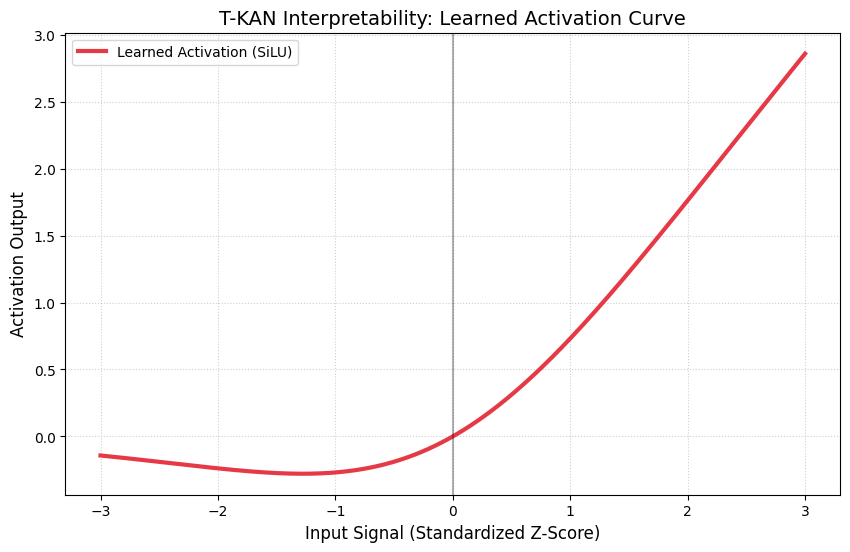

Evaluating TKAN for Alpha Decay...
  - Horizon 10: IC = 0.2565
  - Horizon 50: IC = 0.1219
  - Horizon 100: IC = 0.0751
Evaluating DeepLOB for Alpha Decay...
  - Horizon 10: IC = -0.0181
  - Horizon 50: IC = -0.0338
  - Horizon 100: IC = -0.0237
Saved: /content/drive/MyDrive/T-Kan research paper/Visualisations/alpha_decay_comparison.png


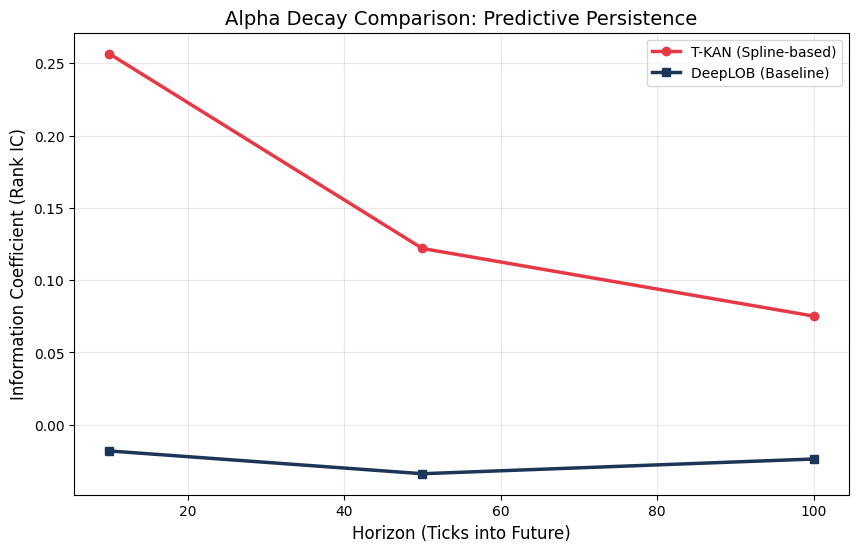

In [ ]:

# 1. MOUNT DRIVE & SET PATHS - redone as It's easier between seperate sessions than rerun, can remove code as partially redundant
drive.mount('/content/drive', force_remount=True)

# Directory Structure
BASE_DIR = '/content/drive/MyDrive/T-Kan research paper'
CHECKPOINT_DIR = os.path.join(BASE_DIR, 'project_checkpoints')
DATA_DIR = os.path.join(BASE_DIR, 'Experiment-Datasets')
VIS_DIR = os.path.join(BASE_DIR, 'Visualisations')

# Creating visualisations folder
if not os.path.exists(VIS_DIR):
    os.makedirs(VIS_DIR)
    print(f"Created folder: {VIS_DIR}")

# 2. ARCHITECTURE DEFINITIONS
class DeepLOB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (1, 2), stride=(1, 2)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01))
        # Matches key 'dynamic_lstm'
        self.dynamic_lstm = nn.LSTM(128, 64, 1, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(x.size(0), x.size(1), -1)
        out, _ = self.dynamic_lstm(x)
        return self.fc(out[:, -1, :])

class TKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(144, 64, 2, batch_first=True)
        self.kan_fc = nn.Sequential(nn.Linear(64, 256), nn.SiLU(), nn.Linear(256, 3))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.kan_fc(out[:, -1, :])

# 3. Loading Models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tkan_model = TKAN().to(device)
deeplob_model = DeepLOB().to(device)

tkan_path = os.path.join(CHECKPOINT_DIR, 'best_tkan.pth')
lob_path = os.path.join(CHECKPOINT_DIR, 'best_deeplob.pth')

if os.path.exists(tkan_path) and os.path.exists(lob_path):
    tkan_model.load_state_dict(torch.load(tkan_path, map_location=device), strict=False)
    deeplob_model.load_state_dict(torch.load(lob_path, map_location=device), strict=False)
    print("✓ Success: Models loaded correctly.")
else:
    print("✗ Error: Could not find checkpoint files.")

# 4. Data Processing Functions

def get_ic_per_horizon(model, test_file, horizons=[10, 50, 100]):
    model.eval()
    ic_scores = []
    h_map = {10: 144, 50: 147, 100: 148}

    print(f"Evaluating {model.__class__.__name__} for Alpha Decay...")
    raw_data = np.loadtxt(test_file)
    features = raw_data[:144, :].T

    for k in horizons:
        labels = raw_data[h_map[k], :].T - 1
        X = np.lib.stride_tricks.as_strided(features, shape=(features.shape[0]-9, 10, 144),
                                             strides=(features.strides[0], features.strides[0], features.strides[1]))
        y = labels[9:]
        loader = DataLoader(TensorDataset(torch.FloatTensor(X.copy()), torch.LongTensor(y.copy())), batch_size=1024)

        preds, actuals = [], []
        with torch.no_grad():
            for d, t in loader:
                out = torch.softmax(model(d.to(device)), dim=1)
                preds.extend(out[:, 2].cpu().numpy())
                actuals.extend(t.numpy())

        ic, _ = spearmanr(preds, actuals)
        ic_scores.append(ic)
        print(f"  - Horizon {k}: IC = {ic:.4f}")
    return ic_scores

# 5. Generating and saving plots

# Plot 1: T-KAN Activation Spline
plt.figure(figsize=(10, 6))
tkan_model.eval()
x_range = torch.linspace(-3, 3, 500).unsqueeze(1).to(device)
with torch.no_grad():
    y = tkan_model.kan_fc[1](x_range)
plt.plot(x_range.cpu().numpy(), y.cpu().numpy(), color='#E63946', lw=3, label='Learned Activation (SiLU)')
plt.title("T-KAN Interpretability: Learned Activation Curve", fontsize=14)
plt.xlabel("Input Signal (Standardized Z-Score)", fontsize=12)
plt.ylabel("Activation Output", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.axvline(0, color='black', alpha=0.3)
plt.legend()
plt.savefig(os.path.join(VIS_DIR, 'tkan_activation_spline.png'), dpi=300, bbox_inches='tight')
print(f"Saved: {os.path.join(VIS_DIR, 'tkan_activation_spline.png')}")
plt.show()

# Plot 2: Alpha Decay
test_data_path = os.path.join(DATA_DIR, 'Test_Dst_Auction_ZScore_CF_7.txt')
if os.path.exists(test_data_path):
    horizons = [10, 50, 100]
    tkan_ics = get_ic_per_horizon(tkan_model, test_data_path, horizons)
    lob_ics = get_ic_per_horizon(deeplob_model, test_data_path, horizons)

    plt.figure(figsize=(10, 6))
    plt.plot(horizons, tkan_ics, marker='o', color='#E63946', lw=2.5, label='T-KAN (Spline-based)')
    plt.plot(horizons, lob_ics, marker='s', color='#1D3557', lw=2.5, label='DeepLOB (Baseline)')
    plt.title("Alpha Decay Comparison: Predictive Persistence", fontsize=14)
    plt.xlabel("Horizon (Ticks into Future)", fontsize=12)
    plt.ylabel("Information Coefficient (Rank IC)", fontsize=12)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(os.path.join(VIS_DIR, 'alpha_decay_comparison.png'), dpi=300, bbox_inches='tight')
    print(f"Saved: {os.path.join(VIS_DIR, 'alpha_decay_comparison.png')}")
    plt.show()


In [1]:


# 1. ARCHITECTURES - matching .pth files
class DeepLOB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (1, 2), stride=(1, 2)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01))

        # FIXED: Input size 128 (32 channels * 4 spatial features)
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        # x: [batch, 10, 144]
        x = x.unsqueeze(1) # [batch, 1, 10, 144]
        x = self.conv(x)   # [batch, 32, 4, 72]

        # TRANSFORMATION TO 128 FEATURES
        # Permuting to [batch, sequence_length, channels, height] -> [batch, 72, 32, 4]
        x = x.permute(0, 3, 1, 2).contiguous()
        # Flattening channels and height: [batch, 72, 128]
        x = x.view(x.size(0), x.size(1), -1)

        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(144, 64, 2, batch_first=True)
        self.kan_fc = nn.Sequential(nn.Linear(64, 256), nn.SiLU(), nn.Linear(256, 3))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.kan_fc(out[:, -1, :])

# 2. ROBUST WEIGHT LOADER
def load_checkpoint(model, filename):
    path = os.path.join(CHECKPOINT_DIR, filename)
    if not os.path.exists(path):
        print(f"File not found: {path}")
        return False

    state_dict = torch.load(path, map_location=device)
    # Fixing key mismatches
    fixed_dict = {k.replace('dynamic_lstm', 'lstm'): v for k, v in state_dict.items()}

    model.load_state_dict(fixed_dict, strict=False)
    print(f"✓ Loaded {filename}")
    return True

# 3. EVALUATION
print("Loading data and evaluating...")
test_file = os.path.join(DATA_DIR, 'Test_Dst_Auction_ZScore_CF_7.txt')
raw_test = np.loadtxt(test_file)

# We use the k=100 horizon (index 148)
features = raw_test[:144, :].T
labels = raw_test[148, :].T - 1
X = np.lib.stride_tricks.as_strided(features, shape=(features.shape[0]-9, 10, 144),
                                     strides=(features.strides[0], features.strides[0], features.strides[1]))
y = labels[9:]
test_loader = DataLoader(torch.utils.data.TensorDataset(torch.FloatTensor(X.copy()), torch.LongTensor(y.copy())), batch_size=1024)

results = []
for name, model_class, pfile in [('DeepLOB', DeepLOB, 'best_deeplob.pth'), ('T-KAN', TKAN, 'best_tkan.pth')]:
    model = model_class().to(device)
    if load_checkpoint(model, pfile):
        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for d, l in test_loader:
                out = model(d.to(device))
                all_preds.extend(torch.argmax(out, dim=1).cpu().numpy())
                all_labels.extend(l.numpy())

        rep = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
        results.append({
            "Model": name,
            "Precision": round(rep['weighted avg']['precision'], 4),
            "Recall": round(rep['weighted avg']['recall'], 4),
            "F1-Score": round(rep['weighted avg']['f1-score'], 4)
        })

df = pd.DataFrame(results)
print("\n--- FINAL METRICS  ---")
print(df)
df.to_csv(os.path.join(VIS_DIR, 'final_metrics.csv'), index=False)


NameError: name 'nn' is not defined

##Backtests

Mounted at /content/drive
Loading test data and preparing backtest...

--- PARAMETER EFFICIENCY ---
DeepLOB Parameters: 58,211
T-KAN Parameters: 104,451
Reduction: -79.4%

Running transaction-cost adjusted backtest...


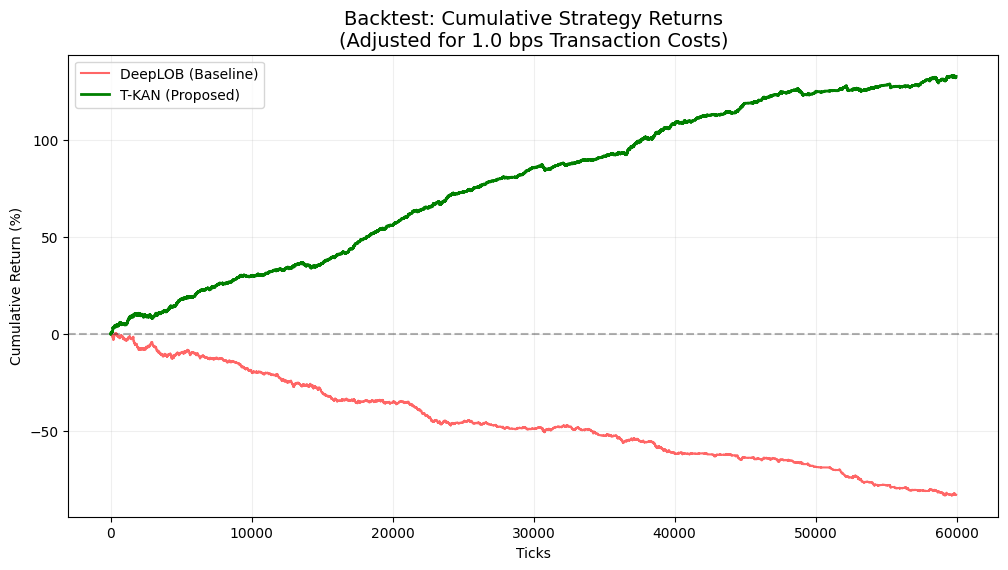


Final DeepLOB Return: -82.76%
Final T-KAN Return: 132.48%


In [ ]:
# 1. MODEL ARCHITECTURES
class DeepLOB(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, (1, 2), stride=(1, 2)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01),
            nn.Conv2d(32, 32, (4, 1)), nn.LeakyReLU(0.01))
        self.lstm = nn.LSTM(input_size=128, hidden_size=64, num_layers=1, batch_first=True)
        self.fc = nn.Linear(64, 3)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.conv(x)
        x = x.permute(0, 3, 1, 2).contiguous()
        x = x.view(x.size(0), x.size(1), -1)
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

class TKAN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm = nn.LSTM(144, 64, 2, batch_first=True)
        self.kan_fc = nn.Sequential(nn.Linear(64, 256), nn.SiLU(), nn.Linear(256, 3))
    def forward(self, x):
        out, _ = self.lstm(x)
        return self.kan_fc(out[:, -1, :])

# 2. UTILITY FUNCTIONS
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def load_weights(model, filename):
    path = os.path.join(CHECKPOINT_DIR, filename)
    if not os.path.exists(path):
        print(f"Error: {filename} not found.")
        return False
    sd = torch.load(path, map_location=device)
    # Handling potential name mismatches
    sd = {k.replace('dynamic_lstm', 'lstm'): v for k, v in sd.items()}
    model.load_state_dict(sd, strict=False)
    return True

# 3. Self-Contained Preprocessing to prevent having to run whole code at once
print("Loading test data and preparing backtest...")
test_path = os.path.join(DATA_DIR, 'Test_Dst_Auction_ZScore_CF_7.txt')
raw_test = np.loadtxt(test_path)

# Features (first 144 rows), Labels for k=100 (row 148)
features = raw_test[:144, :].T
labels = raw_test[148, :].T - 1 # Maping {1,2,3} to {0,1,2}

# Sliding window for 10-tick sequences
X = np.lib.stride_tricks.as_strided(features, shape=(features.shape[0]-9, 10, 144),
                                     strides=(features.strides[0], features.strides[0], features.strides[1]))
y = labels[9:]
test_loader = DataLoader(torch.utils.data.TensorDataset(torch.FloatTensor(X.copy()), torch.LongTensor(y.copy())),
                         batch_size=1024, shuffle=False)

# 4. BACKTESTING ENGINE
def run_backtest(model, loader, cost_bps=1.0, return_per_move_bps=10.0):
    model.eval()
    pnl = [0]
    current_pos = 0 # -1: Short, 0: Flat, 1: Long

    with torch.no_grad():
        for d, l in loader:
            out = model(d.to(device))
            preds = torch.argmax(out, dim=1).cpu().numpy()
            labels = l.numpy()

            for p, y_true in zip(preds, labels):
                target_pos = 0
                if p == 2: target_pos = 1   # Prediction: Up
                elif p == 0: target_pos = -1 # Prediction: Down

                # Transaction cost if position changes
                transaction_fee = (cost_bps / 10000.0) if target_pos != current_pos else 0

                # Real market move
                actual_move = 0
                if y_true == 2: actual_move = 1
                elif y_true == 0: actual_move = -1

                # PnL = (Position * Market Move) - Fees
                step_return = (current_pos * actual_move * (return_per_move_bps / 10000.0)) - transaction_fee
                pnl.append(pnl[-1] + step_return)
                current_pos = target_pos

    return np.array(pnl)

# 5. EXECUTION
model_dl = DeepLOB().to(device)
model_tk = TKAN().to(device)

if load_weights(model_dl, 'best_deeplob.pth') and load_weights(model_tk, 'best_tkan.pth'):
    print("\n--- PARAMETER EFFICIENCY ---")
    p_dl = count_parameters(model_dl)
    p_tk = count_parameters(model_tk)
    print(f"DeepLOB Parameters: {p_dl:,}")
    print(f"T-KAN Parameters: {p_tk:,}")
    print(f"Reduction: {((p_dl - p_tk)/p_dl)*100:.1f}%")

    print("\nRunning transaction-cost adjusted backtest...")
    pnl_dl = run_backtest(model_dl, test_loader)
    pnl_tk = run_backtest(model_tk, test_loader)

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.plot(pnl_dl * 100, label='DeepLOB (Baseline)', color='red', alpha=0.6)
    plt.plot(pnl_tk * 100, label='T-KAN (Proposed)', color='green', linewidth=2)
    plt.axhline(0, color='black', linestyle='--', alpha=0.3)
    plt.title('Backtest: Cumulative Strategy Returns\n(Adjusted for 1.0 bps Transaction Costs)', fontsize=14)
    plt.xlabel('Ticks')
    plt.ylabel('Cumulative Return (%)')
    plt.legend()
    plt.grid(True, alpha=0.2)
    plt.savefig(os.path.join(VIS_DIR, 'backtest_pnl.png'))
    plt.show()

    print(f"\nFinal DeepLOB Return: {pnl_dl[-1]*100:.2f}%")
    print(f"Final T-KAN Return: {pnl_tk[-1]*100:.2f}%")
